## Initial Phase

### Google Colab Upload Widget

In [ ]:
from google.colab import files

uploaded = files.upload()

### Install Gradio for UI

In [ ]:
%pip install gradio --quiet


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


---

# Pet Adoption Recommender System

## Introduction

**Goal**: Develop a recommender system to suggest pets to users based on their preferences and adoption history, enhancing pet adoption outcomes.

**Datasets**:

- `pet_adoption_data.csv`: Pet attributes (e.g., type, breed, size, age).
- `synthetic_user_data.csv`: User profiles (e.g., preferred pet type, living space).
- `adoption_history.csv`: Historical user-pet adoptions.

---

## 1. Data Exploration (Exploratory Data Analysis)

**Goal**: Understand the datasets to inform feature selection and modeling.

**Methodology**:

- Load datasets and inspect their structure.
- Visualize distributions of key features (e.g., pet types, user preferences).
- Check for missing values and anomalies.

**Code**:

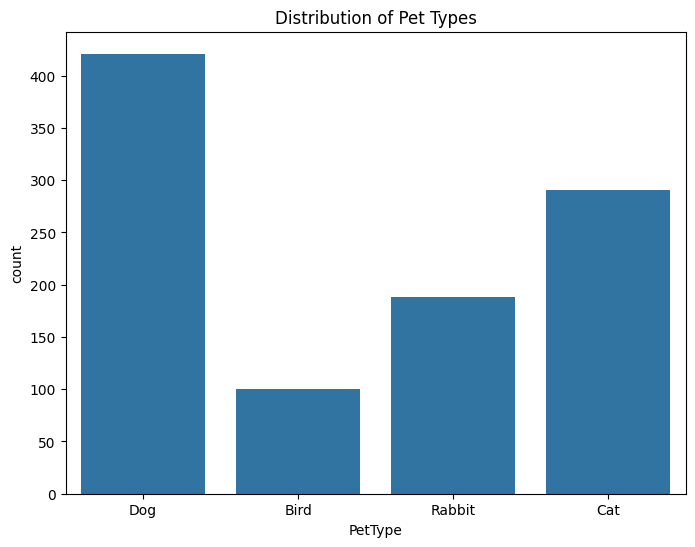

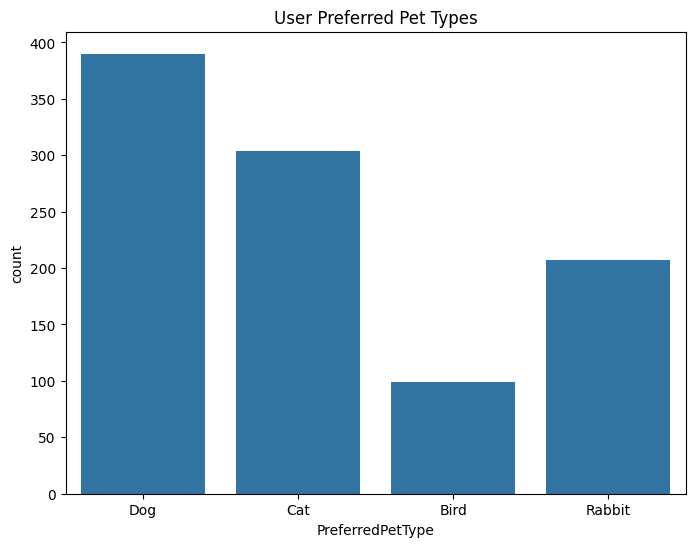

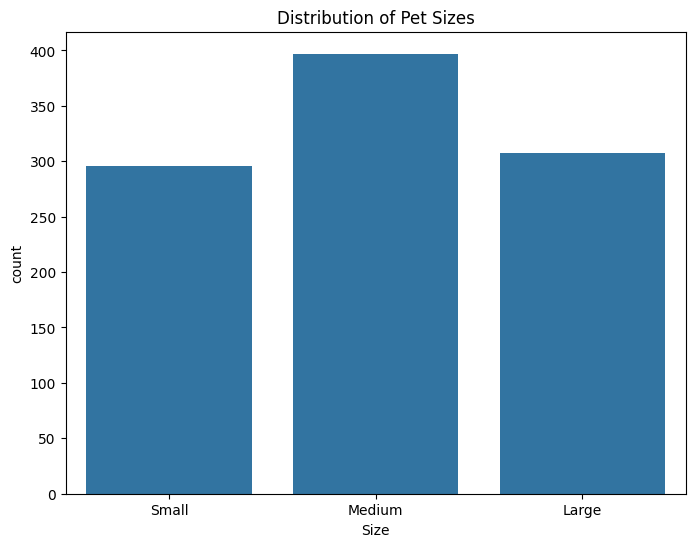

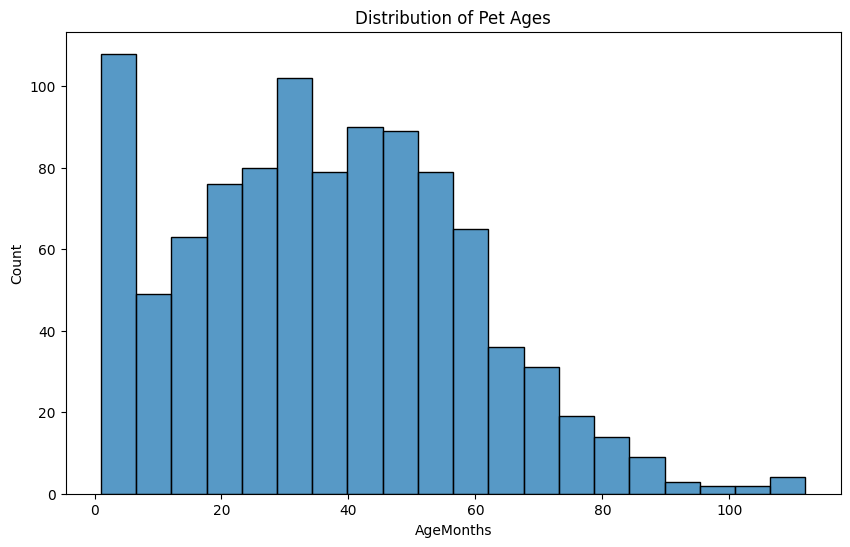

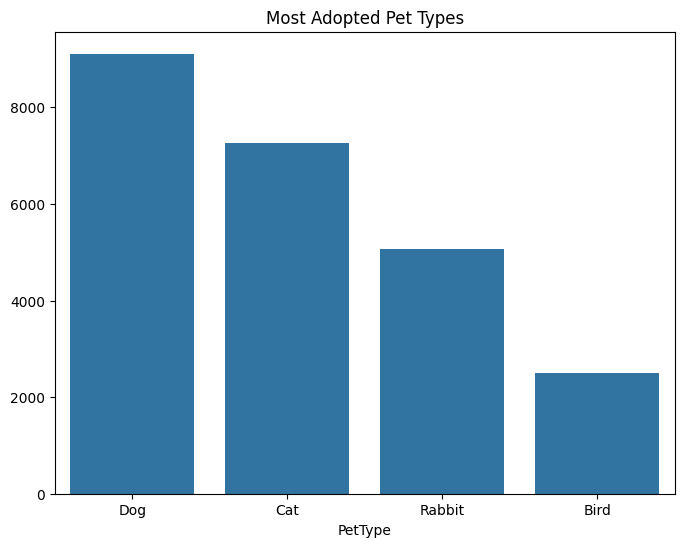

Missing values in pet_df: 0
Missing values in user_df: 308
Missing values in adoption_df: 0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
pet_df_raw = pd.read_csv('content/pet_adoption_data.csv')
user_df_raw = pd.read_csv('content/synthetic_user_data.csv')
adoption_df_raw = pd.read_csv('content/adoption_history.csv')

# Work with copies for preprocessing
pet_df = pet_df_raw.copy()
user_df = user_df_raw.copy()
adoption_df = adoption_df_raw.copy()

# Distribution of pet types
plt.figure(figsize=(8, 6))
sns.countplot(data=pet_df, x='PetType')
plt.title('Distribution of Pet Types')
plt.show()
plt.close()

# Distribution of user preferred pet types
plt.figure(figsize=(8, 6))
sns.countplot(data=user_df, x='PreferredPetType')
plt.title('User Preferred Pet Types')
plt.show()
plt.close()

# Distribution of pet sizes
plt.figure(figsize=(8, 6))
sns.countplot(data=pet_df, x='Size')
plt.title('Distribution of Pet Sizes')
plt.show()
plt.close()

# Distribution of pet ages
plt.figure(figsize=(10, 6))
sns.histplot(data=pet_df, x='AgeMonths', bins=20)
plt.title('Distribution of Pet Ages')
plt.show()
plt.close()

# Most adopted pet types
adoption_counts = adoption_df.merge(pet_df, on='PetID')['PetType'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=adoption_counts.index, y=adoption_counts.values)
plt.title('Most Adopted Pet Types')
plt.show()
plt.close()

# Check missing values
print("Missing values in pet_df:", pet_df.isnull().sum().sum())
print("Missing values in user_df:", user_df.isnull().sum().sum())
print("Missing values in adoption_df:", adoption_df.isnull().sum().sum())

---

## 2. Data Preprocessing

**Goal**: Prepare the data for recommendation systems by standardizing features.

**Methodology**:

- Encode categorical variables (e.g., `PetType`, `Size`) using `LabelEncoder`.
- Normalize numerical features (e.g., `AgeMonths`, `WeightKg`) with `StandardScaler`.
- Create a user-pet interaction matrix for collaborative filtering.

**Code**:

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables for pets
label_encoders = {}
categorical_cols = ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    pet_df[col] = label_encoders[col].fit_transform(pet_df[col].astype(str))

# Encode categorical variables for users
user_categorical_cols = ['PreferredPetType', 'Allergies', 'ActivityLevel', 'PastPetExperience']
for col in user_categorical_cols:
    label_encoders[col] = LabelEncoder()
    user_df[col] = label_encoders[col].fit_transform(user_df[col].astype(str))

# Normalize numerical features
scaler = StandardScaler()
numeric_cols = ['AgeMonths', 'WeightKg', 'TimeInShelterDays', 'AdoptionFee']
pet_df[numeric_cols] = scaler.fit_transform(pet_df[numeric_cols])

# Create user-pet interaction matrix
adoption_df['Interaction'] = 1  # Indicate adoption
user_pet_matrix = adoption_df.pivot(index='UserID', columns='PetID', values='Interaction').fillna(0)

# Compute user similarity for collaborative filtering
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(user_pet_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_pet_matrix.index, columns=user_pet_matrix.index)

print(f"User-Pet Matrix: {user_pet_matrix.shape[0]} users, {user_pet_matrix.shape[1]} pets")

User-Pet Matrix: 1000 users, 1000 pets


---

## Recommendation Systems

### Utility Function

In [4]:
def format_output_as_table(recs, pet_df_raw, scaler=None, label_encoders=None):
    # Create a copy of the recommendations
    recs_display = recs.copy()
    
    # Define columns to display
    display_columns = ['PetID', 'PetType', 'Breed', 'Size', 'AgeMonths', 'WeightKg', 
                       'AdoptionFee', 'HealthCondition', 'EnergyLevel']
    if 'Score' in recs_display.columns:
        display_columns.append('Score')  # Include Score if present
    
    # Filter to only include available columns
    display_columns = [col for col in display_columns if col in recs_display.columns]
    
    # If scaler and label_encoders are provided, decode and unscale
    if scaler is not None and label_encoders is not None:
        categorical_cols = ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']
        for col in categorical_cols:
            if col in recs_display.columns and col in label_encoders:
                recs_display[col] = label_encoders[col].inverse_transform(recs_display[col].astype(int))
        
        numeric_cols = ['AgeMonths', 'WeightKg', 'AdoptionFee']
        for col in numeric_cols:
            if col in recs_display.columns and col in pet_df_raw.columns:
                try:
                    col_index = pet_df_raw.columns.get_loc(col)
                    recs_display[col] = (recs_display[col] * scaler.scale_[col_index]) + scaler.mean_[col_index]
                    if col == 'AdoptionFee':
                        recs_display[col] = recs_display[col].round(2)
                except (IndexError, AttributeError):
                    pass
    
    # Select display columns
    recs_display = recs_display[display_columns]
    
    return recs_display

### Popularity-Based Recommendation

**Goal**: Recommend the most frequently adopted pets.

**Methodology**:
- Calculate adoption frequency per pet.
- Return the top N most adopted pets.

**Algorithm**
- This method identifies the most frequently adopted pets from the `adoption_history.csv` dataset.
- It counts the occurrences of each `PetID` in the adoption history.
- The top N pets with the highest adoption counts are then recommended. This approach is simple and provides generally safe recommendations based on collective behavior.

**Code**:

In [5]:
def popularity_based_recommendations(pet_df, adoption_df, top_n=5):
    popular_pets = adoption_df['PetID'].value_counts().head(top_n).index
    recommendations = pet_df[pet_df['PetID'].isin(popular_pets)].copy()
    return recommendations

# Example: Top 5 most adopted pets
popularity_recs = popularity_based_recommendations(pet_df, adoption_df, top_n=5)
format_output_as_table(popularity_recs, pet_df_raw)

,PetID,PetType,Breed,Size,AgeMonths,WeightKg,AdoptionFee,HealthCondition,EnergyLevel
114,115,1,31,1,-1.111271,0.837971,-1.568785,0,1
679,680,3,18,1,0.792522,-1.942177,-1.568785,2,1
914,915,1,28,1,-0.884629,-0.428932,-1.568785,0,2
932,933,0,1,1,-0.657987,-1.030543,-1.568785,0,1
972,973,3,12,2,0.973835,-0.599863,-1.568785,0,1


**Example Output**: This will display a table of the top 5 most adopted pets (PetID, PetType, Breed, etc.) based on adoption history.

### Content-Based Recommendation

**Goal**: Recommend pets based on how well their features match user preferences.

**Methodology**:
- Match pet attributes (e.g., `PetType`, `EnergyLevel`) with user preferences.
- Use a scoring system to rank pets.

**Algorithm**:
- This method recommends pets by matching their attributes (from `pet_adoption_data.csv`) with the user's stated preferences.
- User preferences include `PreferredPetType`, `Allergies`, `ActivityLevel`, `PastPetExperience`, and `MaxAdoptionFee`.
- Each pet is assigned a "score" based on how well its features align with these preferences. For example:
    + A direct match on `PetType` and `PreferredPetType` increases the score.
    + A match between the pet's `EnergyLevel` and the user's desired `ActivityLevel` increases the score.
    + If the pet's `AdoptionFee` is within the user's `MaxAdoptionFee`, the score increases.
    + If the user has `Allergies`, non-hypoallergenic breeds (e.g., not a Poodle in this simplified logic) might decrease the score.
- Pets with the highest scores are then recommended.

**Code**:

In [6]:
def content_based_recommendations(user_preferences, pet_df, top_n=5):
    scores = []
    adoption_fee_index = numeric_cols.index('AdoptionFee')  
    
    for _, pet in pet_df.iterrows():
        score = 0
        # Match PetType
        if pet['PetType'] == user_preferences['PreferredPetType']:
            score += 2 # Higher weight for PetType match
        # Match EnergyLevel with ActivityLevel
        if pet['EnergyLevel'] == user_preferences['ActivityLevel']:
            score += 1
        original_adoption_fee = (pet['AdoptionFee'] * scaler.scale_[adoption_fee_index]) + scaler.mean_[adoption_fee_index]
        # Check AdoptionFee against user's max
        if original_adoption_fee <= user_preferences['MaxAdoptionFee']:
            score += 1
        # Allergies
        if user_preferences['Allergies'] == 1 and pet['Breed'] not in [label_encoders['Breed'].transform(['Poodle'])[0]]:
            score -= 1
        scores.append(score)
    
    pet_df_copy = pet_df.copy()
    pet_df_copy['Score'] = scores
    recommendations = pet_df_copy.sort_values(by='Score', ascending=False).head(top_n)
    return recommendations  

# Example usage
sample_prefs = {
    'PreferredPetType': label_encoders['PetType'].transform(['Dog'])[0],
    'Allergies': 0,
    'ActivityLevel': 1,
    'MaxAdoptionFee': 300
}
content_recs = content_based_recommendations(sample_prefs, pet_df, top_n=5)
format_output_as_table(content_recs, pet_df_raw)

,PetID,PetType,Breed,Size,AgeMonths,WeightKg,AdoptionFee,HealthCondition,EnergyLevel,Score
15,16,2,35,0,0.520551,0.640227,0.724869,0,1,4
995,996,2,3,1,-0.657987,1.459692,0.824766,1,1,4
410,411,2,3,2,0.520551,-0.546238,-0.614805,0,1,4
962,963,2,17,0,-0.204703,0.422373,-0.167365,0,1,4
36,37,2,3,1,-0.929957,-0.819393,0.148203,0,1,4


**Example Output**: This will show a table of 5 pets matching the preferences (e.g., dogs with high energy, adoption fee ≤ $300).

### Collaborative Filtering

**Goal**: Recommend pets based on adoption patterns of similar users.

**Methodology**:
- Use the user-pet interaction matrix to compute user similarities.
- Recommend pets adopted by similar users.

**Algorithm**:

- This method recommends pets based on the adoption patterns of users who are similar to the target user.
- It first builds a user-pet interaction matrix from `adoption_history.csv`, where rows are users, columns are pets, and values indicate an adoption.
- It then calculates the similarity between users (e.g., using cosine similarity on their adoption vectors).
- For a given `UserID`, it identifies the most similar users.
- It then recommends pets that these similar users have adopted but the target user has not yet adopted.
- If the `UserID` is not found in the history, it defaults to showing popularity-based recommendations.

**Code**:

In [7]:
def collaborative_filtering_recommendations(user_id, user_pet_matrix, user_similarity_df, pet_df, top_n=5):
    if user_id not in user_pet_matrix.index:
        return popularity_based_recommendations(pet_df, adoption_df, top_n)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:11]  # Top 10 similar users
    recommended_pets = []
    for similar_user in similar_users:
        pets = user_pet_matrix.loc[similar_user][user_pet_matrix.loc[similar_user] == 1].index
        for pet in pets:
            if pet not in user_pet_matrix.loc[user_id][user_pet_matrix.loc[user_id] == 1].index:
                recommended_pets.append(pet)
            if len(recommended_pets) >= top_n:
                break
        if len(recommended_pets) >= top_n:
            break
    return pet_df[pet_df['PetID'].isin(recommended_pets)].head(top_n)

# Sample UserID from dataset
sample_user_id = 42

# Get recommendations
collab_recs = collaborative_filtering_recommendations(sample_user_id, user_pet_matrix, user_similarity_df, pet_df, top_n=5)
format_output_as_table(collab_recs, pet_df_raw)

,PetID,PetType,Breed,Size,AgeMonths,WeightKg,AdoptionFee,HealthCondition,EnergyLevel
28,29,1,34,1,0.157924,0.358693,-1.229401,0,1
29,30,2,11,0,1.200477,0.375451,0.124166,1,1
154,155,0,14,1,0.701865,0.130784,-1.568785,0,0
173,174,2,17,2,1.155149,-0.011659,0.354171,0,1
199,200,3,25,2,0.701865,1.566943,-0.684049,0,1


**Example Output**: This will display a table of 5 recommended pets for UserID 42 based on similar users’ adoptions.

---

## Gradio Interface

**Goal**: Provide an interactive UI for users to input preferences and receive recommendations.

**Methodology**:
- Use Gradio to create input fields for preferences and a method selector.
- Display recommendations in a table format.

In [8]:
import gradio as gr

def recommend_pets(method, preferred_pet_type, allergies, activity_level, past_experience, max_fee, user_id):
    # Prepare display DataFrame by decoding categorical variables
    pet_df_display = pet_df.copy()
    categorical_cols = ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']
    for col in categorical_cols:
        pet_df_display[col] = label_encoders[col].inverse_transform(pet_df_display[col])
    
    if method == 'Popularity':
        recs = popularity_based_recommendations(pet_df, adoption_df)
    elif method == 'Content-Based':
        if not all([preferred_pet_type, activity_level, past_experience, max_fee is not None]):
            return "Please fill in all preference fields for Content-Based recommendations."
        user_prefs = {
            'PreferredPetType': label_encoders['PetType'].transform([preferred_pet_type])[0],
            'Allergies': 1 if allergies else 0,
            'ActivityLevel': label_encoders['EnergyLevel'].transform([activity_level])[0],
            'PastPetExperience': label_encoders['PastPetExperience'].transform([past_experience])[0],
            'MaxAdoptionFee': max_fee
        }
        recs = content_based_recommendations(user_prefs, pet_df)
        # Decode categorical columns in recs
        for col in categorical_cols:
            recs[col] = label_encoders[col].inverse_transform(recs[col])
        numeric_cols = ['AgeMonths', 'WeightKg', 'TimeInShelterDays', 'AdoptionFee']
        adoption_fee_index = numeric_cols.index('AdoptionFee')
        recs['AdoptionFee'] = (recs['AdoptionFee'] * scaler.scale_[adoption_fee_index]) + scaler.mean_[adoption_fee_index]
        recs['AdoptionFee'] = recs['AdoptionFee'].round(2)
        # Select display columns, including Score
        display_columns = ['PetID', 'PetType', 'Breed', 'Size', 'AgeMonths', 'WeightKg', 'AdoptionFee', 'HealthCondition', 'EnergyLevel', 'Score']
        recs_display = recs[display_columns]
    elif method == 'Collaborative Filtering':
        if not user_id or user_id.strip() == "":
            return "Please enter a valid User ID for Collaborative Filtering."
        try:
            user_id = int(user_id)
            recs = collaborative_filtering_recommendations(user_id, user_pet_matrix, user_similarity_df, pet_df)
        except ValueError:
            return "Invalid User ID. Please enter a numeric value."
    else:
        return "Invalid recommendation method selected."
    
    if method != 'Content-Based':
        # For Popularity and Collaborative Filtering, filter from pet_df_display and exclude 'TimeInShelterDays'
        recs_display = pet_df_display[pet_df_display['PetID'].isin(recs['PetID'])].drop(columns=['TimeInShelterDays'], errors='ignore')
        numeric_cols = ['AgeMonths', 'WeightKg', 'TimeInShelterDays', 'AdoptionFee']
        adoption_fee_index = numeric_cols.index('AdoptionFee')
        recs_display['AdoptionFee'] = (recs_display['AdoptionFee'] * scaler.scale_[adoption_fee_index]) + scaler.mean_[adoption_fee_index]
        recs_display['AdoptionFee'] = recs_display['AdoptionFee'].round(2)
    
    if isinstance(recs_display, str):
        return recs_display
    
    return recs_display

with gr.Blocks(title="Pet Adoption Recommender") as app:
    # Instructions that update based on method
    instructions = gr.Markdown("Select a recommendation method to begin.")
    
    # Method selection
    method_input = gr.Radio(
        choices=['Popularity', 'Content-Based', 'Collaborative Filtering'],
        label='Recommendation Method',
        value='Popularity'  # Default value
    )
    
    # Preferences column (hidden by default)
    with gr.Column(visible=False) as preferences_column:
        preferred_pet_type_input = gr.Dropdown(
            choices=list(label_encoders['PetType'].classes_),
            label='Preferred Pet Type'
        )
        allergies_input = gr.Checkbox(label='Allergies')
        activity_level_input = gr.Dropdown(
            choices=list(label_encoders['EnergyLevel'].classes_),
            label='Activity Level'
        )
        past_experience_input = gr.Dropdown(
            choices=list(label_encoders['PastPetExperience'].classes_),
            label='Past Pet Experience'
        )
        max_fee_input = gr.Slider(
            minimum=50,
            maximum=500,
            step=10,
            label='Max Adoption Fee ($)'
        )
    
    # User ID column (hidden by default)
    with gr.Column(visible=False) as user_id_column:
        user_id_input = gr.Textbox(
            label='User ID (for Collaborative Filtering)',
            placeholder='Enter User ID (e.g., 42)'
        )
    
    # Submit button and output
    submit_button = gr.Button('Get Recommendations')
    output = gr.Dataframe(label='Recommended Pets')
    
    # Function to update visibility of input sections
    def update_visibility(method):
        if method == 'Content-Based':
            return gr.update(visible=True), gr.update(visible=False)
        elif method == 'Collaborative Filtering':
            return gr.update(visible=False), gr.update(visible=True)
        else:  # Popularity
            return gr.update(visible=False), gr.update(visible=False)
    
    # Function to update instructions
    def update_instructions(method):
        if method == 'Content-Based':
            return "Please provide your preferences below for personalized recommendations."
        elif method == 'Collaborative Filtering':
            return "Please enter your User ID for recommendations based on similar users."
        else:
            return "Click 'Get Recommendations' to see the most popular pets."
    
    # Bind method change events
    method_input.change(
        fn=update_visibility,
        inputs=method_input,
        outputs=[preferences_column, user_id_column]
    )
    method_input.change(
        fn=update_instructions,
        inputs=method_input,
        outputs=instructions
    )
    
    # Bind submit button
    submit_button.click(
        fn=recommend_pets,
        inputs=[
            method_input,
            preferred_pet_type_input,
            allergies_input,
            activity_level_input,
            past_experience_input,
            max_fee_input,
            user_id_input
        ],
        outputs=output
    )

app.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://bf91cdf16227292a39.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Notes**:

- The interface allows users to choose between Popularity, Content-Based, and Collaborative Filtering methods.
- Output is a table with readable (decoded) pet attributes.